# Project in TNM098 VT 2018, VAST Challenge MC2 2015

This project will explore data containing phone calls between people in an amusement park. The questions that will be answered are:

1. Identify those IDs that stand out for their large volumes of communication. For each of these IDs
  1. Characterize the communication patterns you see.
  2. Based on these patterns, what do you hypothesize about these IDs?

Please limit your response to no more than 4 images and 300 words.

2. Describe up to 10 communications patterns in the data. Characterize who is communicating, with whom, when and where. If you have more than 10 patterns to report, please prioritize those patterns that are most likely to relate to the crime.

Please limit your response to no more than 10 images and 1000 words.

#### My approach:
To start solving the first problem, I would filter out all communication from the IDs with large volumes. From that I would try to visualize the following:
* With who are these persons are communicating with?
* From what places?
* Where is the recipient located?
* What time of the day?
* Do the recipients communicate with each other?
* And more possible properties of the communication data that are relevant


First, start with imports.

In [22]:
import numpy as np
import pandas as pd
import nvd3
import ipywidgets as widgets
from IPython.display import display, HTML
import datetime
import time
import networkx as nx
from nvd3 import stackedAreaChart
import matplotlib.pyplot as plt

#import pylab
#import plotly.plotly as py

Read in the data for Friday.
Pandas series is a vector and a dataframe is a matrix of series.

In [2]:
data_Fri = pd.read_csv("data/comm-data-Fri.csv")
#type(data_Fri): pandas.core.frame.DataFrame
#data_Fri.head(): gives 5 first elements


#	Timestamp 			from 		to 			location
#0 	2014-6-06 08:03:19 	439105 		1053224 	Kiddie Land
#1 	2014-6-06 08:03:19 	439105 		1696241 	Kiddie Land
#2 	2014-6-06 08:03:19 	439105 		580064 		Kiddie Land
#3 	2014-6-06 08:03:19 	439105 		1464748 	Kiddie Land
#4 	2014-6-06 08:03:47 	1836139 	1593258 	Entry Corridor


Find out which senders stand out for their large communication volumes. Pick the five largest.

In [3]:
#Count occurrences for each sender
from_data = data_Fri['from']
to_data = data_Fri['to']
send_counts = from_data.value_counts()
receive_counts = to_data.value_counts()

#print(send_counts)
#print(receive_counts)

#send_average = send_counts.mean()
#receive_average = receive_counts.mean()

too_low_senders = send_counts[send_counts <= 1650].index
highest_senders = send_counts.drop(too_low_senders)

too_low_receivers = receive_counts[receive_counts <= 1350].index
# Remove 'external' from receivers
too_low_receivers = too_low_receivers.append(pd.Index(['external']))
highest_receivers = receive_counts.drop(too_low_receivers)

#print(highest_senders)
#print(highest_receivers)

Different ways to access the data in the DataFrame

In [4]:
#data_Fri.loc[0:1, ['to', 'location']]
#data_Fri['from']

In [5]:
widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)
#display(w)

Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

Use nvd3 to construct the plot, and export it to view as html.

In [6]:
nvd3.ipynb.initialize_javascript(use_remote=True)

chart_type = 'discreteBarChart'
chart = nvd3.discreteBarChart(name="highest_senders", height=700, width=1500)

ydata = highest_senders.to_list()
xdata = list(highest_senders.keys())

chart.add_serie(y=ydata, x=xdata)
chart.buildhtml()
chart_html = chart.htmlcontent

# The chart in html code
#chart_html

# Show the plot
display(HTML(chart_html))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Since 1278894 is clearly the biggest sender and receiver, a closer look will be made on its communication patterns.

In [68]:
# Function for fixing date format in data to be able to compare dates
def convert_to_datetime(str_date):
    #print(str_date)
    date = str_date[0:5] + "0" + str_date[5:]
    return datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")

In [69]:
# Get all data where 1278894 is the sender
sender_1278894 = data_Fri[data_Fri['from'] == 1278894]

timestamp_counts = sender_1278894['Timestamp'].value_counts()
timestamp_counts.sort_index(inplace=True)

#sorted_counts.to_list()
#list(sorted_counts.keys())

In [70]:

chart = stackedAreaChart(name='stackedAreaChart', x_is_date=True, date_format="%d %b %Y", height=700, width=1500)

# Datetimes on x-axis
xdata = [convert_to_datetime(x) for x in list(timestamp_counts.keys())]
xdata = [time.mktime(s.timetuple()) * 1000 for s in xdata]

ydata = timestamp_counts.to_list()

extra_serie = {"tooltip": {"y_start": "There is ", "y_end": " min"}}
chart.add_serie(name="Serie 1", y=ydata, x=xdata, extra=extra_serie)

chart.buildhtml()

chart_html = chart.htmlcontent

# Show the plot
display(HTML(chart_html))

## Biggest receivers of 1278894

In [71]:
to_counts = sender_1278894['to'].value_counts()
#to_counts.sort_index(inplace=True)

chart_type = 'discreteBarChart'
chart = nvd3.discreteBarChart(name="to_counts", height=700, width=1500)

ydata = to_counts.to_list()
xdata = list(to_counts.keys())

chart.add_serie(y=ydata, x=xdata)
chart.buildhtml()
chart_html = chart.htmlcontent

# Show the plot
display(HTML(chart_html))

In [11]:
# Extract all separate data for all recipients
sender_1278894 = data_Fri[data_Fri['from'] == 1278894]
unique_recipients = sender_1278894.to.unique()
print(len(unique_recipients))

# Get all the timestamps for the x-axis 
# and set counter to zero for all to be 
# able to merge with individual recipients data later
timestamps = pd.Series(0, sender_1278894.Timestamp.unique(), name='ts')

separated_sender_lists = {}
for recipient in unique_recipients:
    # Take only the values for current recipient
    separated_sender_recipient = sender_1278894[sender_1278894['to'] == recipient]
    # Count all the messages for each timestamp
    separated_sender_recipient_counts = separated_sender_recipient['Timestamp'].value_counts()
    # Join with timestamps to get zeros where there is no communication
    separated_sender_lists[recipient] = pd.merge(separated_sender_recipient_counts, timestamps, how='outer', left_index=True, right_index=True)
    # Replace NaN with 0
    separated_sender_lists[recipient].fillna(0, inplace=True)
    # Sort based on timestamp
    separated_sender_lists[recipient].sort_index(inplace=True)
    # Remove redundant column with zeros
    separated_sender_lists[recipient].drop('ts', axis=1, inplace=True)

776


In [12]:
chart = stackedAreaChart(name='stackedAreaChart2', x_is_date=True, date_format="%d %b %Y", height=3400, width=1500)

# Datetimes on x-axis
xdata = [convert_to_datetime(x) for x in list(timestamps.keys())]
xdata = [time.mktime(s.timetuple()) * 1000 for s in xdata]

extra_serie = {"tooltip": {"y_start": "There is ", "y_end": " min"}}
for recipient in separated_sender_lists:
    chart.add_serie(name=str(recipient), y=separated_sender_lists[recipient]['Timestamp'], x=xdata, extra=extra_serie)
#chart.add_serie(name="Serie 2", y=ydata2, x=xdata, extra=extra_serie)
chart.buildhtml()

chart_html = chart.htmlcontent

# Show the plot
display(HTML(chart_html))

In [19]:
#import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)         # initiate notebook for offline plot

"""trace0 = go.Scatter(
  x=[1, 2, 3, 4],
  y=[10, 15, 13, 17]
)
trace1 = go.Scatter(
  x=[1, 2, 3, 4],
  y=[16, 5, 11, 9]
)
data = go.Data([trace0, trace1])"""

#plotly.offline.
#iplot(data)               # use plotly.offline.iplot for offline plot

####################################

trace = go.Scatter( 
    x=[1, 2, 2, 1], 
    y=[3, 4, 3, 4], 
    mode='markers',
    marker=dict(size=[100, 100, 100, 100])
)

# Edges
x0 = [1, 2]
y0 = [3, 3]
x1 = [2, 1]
y1 = [4, 4]

fig = go.Figure(
    data=[trace],
    layout=go.Layout(
        annotations = [
            dict(ax=x0[i], ay=y0[i], axref='x', ayref='y',
                x=x1[i], y=y1[i], xref='x', yref='y') for i in range(0, len(x0))
        ]
    )
) 
iplot(fig)

[0, 0, 0, 0]


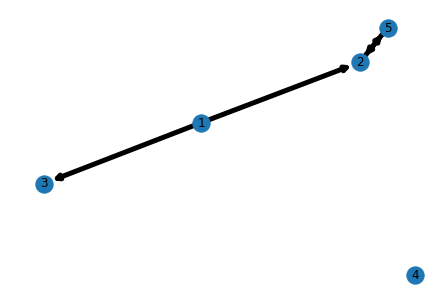

In [55]:
G = nx.MultiDiGraph()
G.add_nodes_from([1,2,3,4,5])
keys = G.add_edges_from([(1, 2), (1, 3), (2, 5), (5, 2)])
print(keys)
nx.draw(G, arrows=True, with_labels=True, width=5)

In [63]:
G_sender_1278894 = nx.DiGraph()
G_sender_1278894.add_node(1278894)
weights = {}
for index, row in sender_1278894.iterrows():
    if row['to'] not in G_sender_1278894:
        G_sender_1278894.add_edge(1278894, row['to'])
        weights[row['to']] = 1
    else:
        weights[row['to']] += 1
        
#print(weights)

{'1231028': 42, '626177': 55, '1281941': 47, '96504': 42, '256620': 44, '656123': 55, '1295204': 48, '1688081': 57, '953336': 56, '142394': 45, '1242773': 55, '477978': 46, '856067': 47, '315002': 35, '1399755': 43, '1207988': 50, '1255453': 53, '69530': 55, '2057936': 57, '37693': 52, '974601': 45, '1358002': 53, '1846010': 51, '2022703': 46, '469296': 54, '1865282': 44, '885675': 53, '1648997': 53, '1412631': 45, '284296': 56, '1138420': 42, '210814': 59, '565351': 48, '682679': 53, '173102': 51, '1683303': 55, '998192': 49, '44403': 46, '1298361': 49, '999011': 53, '1940907': 54, '989161': 35, '1191435': 46, '1745223': 54, '1234191': 53, '864018': 58, '667855': 44, '1861684': 56, '1697086': 54, '1272536': 54, '1926243': 45, '1687109': 59, '714238': 56, '90317': 52, '51893': 55, '795501': 57, '1523396': 58, '1028556': 56, '875548': 48, '1912012': 42, '1156155': 43, '986021': 52, '804851': 54, '1332962': 55, '629470': 51, '840221': 44, '933372': 44, '1535130': 58, '74616': 46, '266349

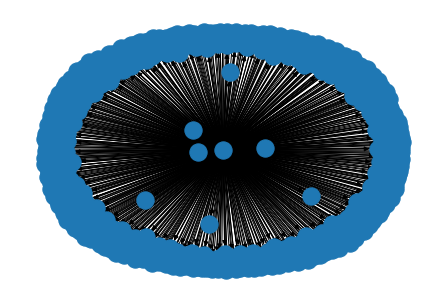

In [67]:
nx.draw(G_sender_1278894)